In [12]:
# Connect to your Google Drive Account
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Change the working directory
import os
os.chdir("/content/drive/MyDrive/Applied Learning/Lab Sessions/Final Project") #Copy and paste your current directory where this notebook is located

In [14]:
#Define Beam Equations (constants are for a steel beam)
#Inputs: Width (w) & Height (h)
  #Weight = ρ × Volume = ρ × (w × h × L)
  #Moment of Inertia (I) = (w × h³) / 12
  #Stress = (M × y) / I
  #Deflection = (F × L³) / (3 × E × I)
import numpy as np

def beam_analysis(w, h, L=1.0, F=100.0, E=200e9, rho=7850):
    I = (w * h**3) / 12
    y = h / 2
    stress = (F * L * y) / I
    deflection = (F * L**3) / (3 * E * I)
    weight = rho * w * h * L
    return weight, stress, deflection


In [15]:
#Generate Synthetic Dataset
#Loop over different widths and heights... find stress, deflection, weight
import pandas as pd

w_vals = np.linspace(0.01, 0.1, 50)
h_vals = np.linspace(0.01, 0.2, 50)

data = []

for w in w_vals:
    for h in h_vals:
        weight, stress, deflection = beam_analysis(w, h)
        data.append([w, h, weight, stress, deflection])

df = pd.DataFrame(data, columns=["width", "height", "weight", "stress", "deflection"])
df.to_csv("beam_dataset.csv", index=False)


In [16]:
#Train Neural Network (Surrogate Model)
#Load the dataset and build a regression model with PyTorch --> predict stress and deflection from w and h

import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load and normalize data
X = df[["width", "height"]].values
y = df[["stress", "deflection"]].values

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Torch Datasets
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

# Model
model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 64),
    nn.ReLU(),
    nn.Linear(64, 2)
)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
for epoch in range(1000):
    y_pred = model(X_train_tensor)
    loss = loss_fn(y_pred, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.0953
Epoch 100, Loss: 0.0282
Epoch 200, Loss: 0.0096
Epoch 300, Loss: 0.0058
Epoch 400, Loss: 0.0018
Epoch 500, Loss: 0.0010
Epoch 600, Loss: 0.0018
Epoch 700, Loss: 0.0010
Epoch 800, Loss: 0.0011
Epoch 900, Loss: 0.0002


In [17]:
from sklearn.metrics import mean_squared_error

# Predict on test set
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_pred_test = model(X_test_tensor).detach().numpy()
y_pred_test = scaler_y.inverse_transform(y_pred_test)
y_test_orig = scaler_y.inverse_transform(y_test)

#MSE
mse_stress = mean_squared_error(y_test_orig[:, 0], y_pred_test[:, 0])
mse_deflection = mean_squared_error(y_test_orig[:, 1], y_pred_test[:, 1])

print(f"Test MSE - Stress: {mse_stress:.2e}")
print(f"Test MSE - Deflection: {mse_deflection:.2e}")


Test MSE - Stress: 3.43e+11
Test MSE - Deflection: 2.36e-08


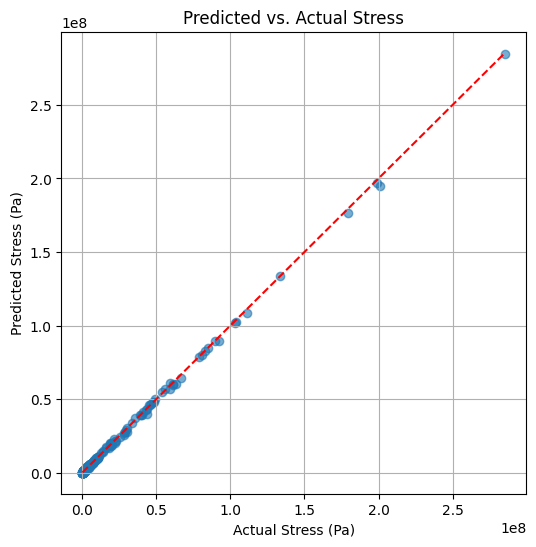

In [18]:
#Plotting Predicted vs. Actual Stress
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(y_test_orig[:, 0], y_pred_test[:, 0], alpha=0.6)
plt.xlabel("Actual Stress (Pa)")
plt.ylabel("Predicted Stress (Pa)")
plt.title("Predicted vs. Actual Stress")
plt.plot([min(y_test_orig[:, 0]), max(y_test_orig[:, 0])],
         [min(y_test_orig[:, 0]), max(y_test_orig[:, 0])], 'r--')  # Perfect Predictions
plt.grid(True)
plt.show()


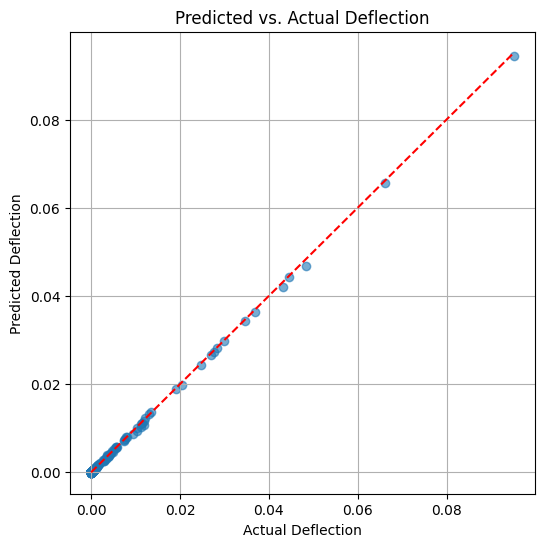

In [19]:
#Plotting Predicted vs. Actual Deflection
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(y_test_orig[:, 1], y_pred_test[:, 1], alpha=0.6)
plt.xlabel("Actual Deflection")
plt.ylabel("Predicted Deflection")
plt.title("Predicted vs. Actual Deflection")
plt.plot([min(y_test_orig[:, 1]), max(y_test_orig[:, 1])],
         [min(y_test_orig[:, 1]), max(y_test_orig[:, 1])], 'r--')  # Perfect Predictions
plt.grid(True)
plt.show()

In [20]:
#Find Optimized Dimensions
from scipy.optimize import minimize

def surrogate_objective(x):
    # Normalize input
    x_scaled = scaler_X.transform([x])
    x_tensor = torch.tensor(x_scaled, dtype=torch.float32)
    y_pred = model(x_tensor).detach().numpy()
    stress, deflection = scaler_y.inverse_transform(y_pred)[0]

    # Compute weight manually
    w, h = x
    weight = 7850 * w * h * 1.0

    # Constraint: stress below threshold
    if stress > 250e6:
        return 1e6  # throwing large number as penalty
    if deflection > 0.005:
        return 1e6
    return weight


# Bounds: (min, max) for width and height
res = minimize(surrogate_objective, x0=[0.05, 0.05], bounds=[(0.01, 0.1), (0.01, 0.2)])
print("Optimized dimensions:", res.x)


Optimized dimensions: [0.0256 0.0256]


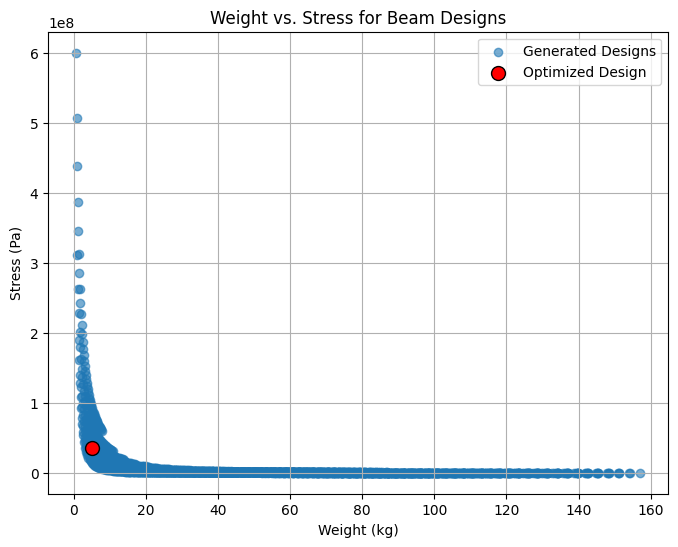

In [21]:

#Visualize Results
#Plot weight vs. stress or deflection with matplotlib.
import matplotlib.pyplot as plt

#Plot the full dataset
plt.figure(figsize=(8, 6))
plt.scatter(df["weight"], df["stress"], label="Generated Designs", alpha=0.6)

#Plot the optimized design
opt_w, opt_h = res.x  # Optimized width and height
opt_weight, opt_stress, _ = beam_analysis(opt_w, opt_h)
plt.scatter(opt_weight, opt_stress, color="red", s=100, label="Optimized Design", edgecolors='black')

#Labels, Title
plt.xlabel("Weight (kg)")
plt.ylabel("Stress (Pa)")
plt.title("Weight vs. Stress for Beam Designs")
plt.legend()
plt.grid(True)


plt.show()


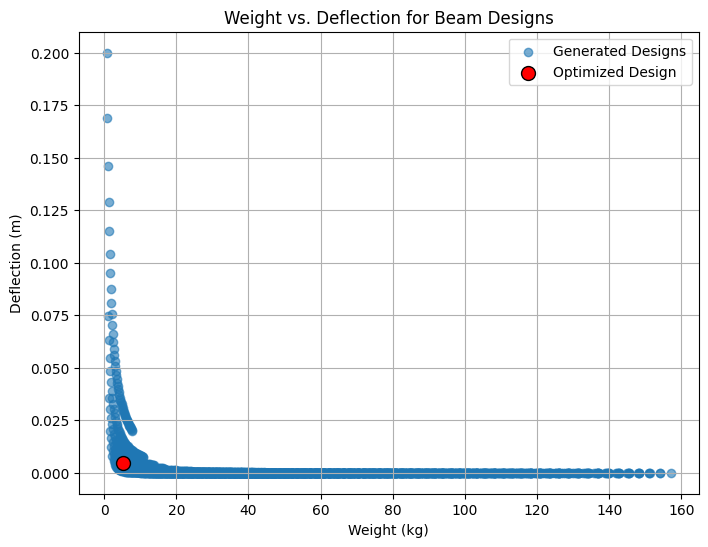

In [22]:
#Plot the full dataset
plt.figure(figsize=(8, 6))
plt.scatter(df["weight"], df["deflection"], label="Generated Designs", alpha=0.6)

#Plot the optimized design
_, _, opt_deflection = beam_analysis(opt_w, opt_h)
plt.scatter(opt_weight, opt_deflection, color="red", s=100, label="Optimized Design", edgecolors='black')

#Labels, Title
plt.xlabel("Weight (kg)")
plt.ylabel("Deflection (m)")
plt.title("Weight vs. Deflection for Beam Designs")
plt.legend()
plt.grid(True)


plt.show()
